# Carregando Pacotes

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pathlib import Path
import os
from matplotlib import pyplot as plt
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

2022-06-19 20:51:56.032192: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print(tf.__version__)

2.4.1


# Parâmetros

In [3]:
# Tamanho imagem
img_rows, img_cols = 224, 224

input_shape = (img_rows, img_cols, 3)

# Batch size

batch_size = 32

# seed
seed = 42

path_dataset = Path('/scratch/dpfurtado/backup_home/corais/1_classificacao_train_50/dataset/1_train_50')
path_train = path_dataset/'train'
path_train_dev = path_dataset/'test_1_2'

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

# Carregando Base de Dados

In [4]:
train_dataset = image_dataset_from_directory(
        path_train,
        image_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=False) # Manter Shuffle = False, pois não haverá treinamento
test_dataset = image_dataset_from_directory(
        path_train_dev,
        image_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=False)

Found 788 files belonging to 7 classes.
Found 168 files belonging to 7 classes.


2022-06-19 20:51:59.443416: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-19 20:51:59.445414: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-19 20:52:00.339327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA GeForce GTX TITAN Black computeCapability: 3.5
coreClock: 0.98GHz coreCount: 15 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 312.92GiB/s
2022-06-19 20:52:00.339913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA GeForce GTX TITAN Black computeCapability: 3.5
coreClock: 0.98GHz coreCount: 15 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 312.92GiB/s
2022-06-19 20:52:00.339943: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcu

In [5]:
# Index para classe 
classes = train_dataset.class_names #Essa função e .file_paths não podem ser usados após o prefetch
classes_dict = dict(enumerate(classes)) 
print(classes_dict)

{0: 'agaricia_spp', 1: 'favia_gravida', 2: 'millepora_alcicornis', 3: 'montastraea_cavernosa', 4: 'palythoa_caribaeorum', 5: 'porites_astreoides', 6: 'siderastrea_stellata'}


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE) #Otimização
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Carregando Modelo

In [7]:
path_modelo = './model/resnet101_imagenet/'

In [8]:
best_model = tf.keras.models.load_model(path_modelo)

In [9]:
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

# Analisando Classe 3

In [10]:
class_index = 2
print(classes_dict[class_index]) 

millepora_alcicornis


In [11]:
path_dir_red_fox =  path_train_dev/'millepora_alcicornis/'

In [12]:
red_fox_dataset = test_dataset.unbatch().filter(lambda x, y: y == class_index).batch(batch_size)

In [13]:
predict_red_fox=best_model.predict(red_fox_dataset)
predict_red_fox_classes = np.argmax(predict_red_fox, axis=1)

2022-06-19 20:52:23.583036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-19 20:52:23.604882: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2022-06-19 20:52:25.589115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-19 20:52:26.318343: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [14]:
list_index_red_fox = np.where(predict_red_fox_classes != class_index)

In [15]:
print(list_index_red_fox[0])

[ 4  5 17 18 28 31 32]


In [16]:
path_imgs = os.listdir(path_dir_red_fox)
path_imgs.sort()

In [17]:
for img_incorrect in list_index_red_fox[0]:
  print(path_imgs[img_incorrect])

2019-09-03_22-46-09_UTC_2.jpg
2019-09-03_22-46-09_UTC_3.jpg
2020-01-13_23-57-51_UTC.jpg
2020-01-15_09-04-12_UTC.jpg
2020-11-08_17-59-34_UTC.jpg
2021-05-29_21-13-46_UTC.jpg
2021-10-05_19-26-31_UTC.jpg


# LIME

In [18]:
# Descobrindo o index da image
index_correta = path_imgs.index('2020-01-02_01-46-48_UTC.jpg')
print(index_correta)

16


In [19]:
imagem_correta, label_imagem_correta = list(red_fox_dataset.unbatch().as_numpy_iterator())[index_correta]

In [20]:
def decode(softmax):
    prob = []
    for key, value in classes_dict.items():
        prob_classe = softmax[key]
        prob.append((value, prob_classe))
    prob.sort(key=lambda x:x[1], reverse=True)
    return prob

Classe: millepora_alcicornis - Probabilidade: 0.988472
Classe: porites_astreoides - Probabilidade: 0.010271
Classe: favia_gravida - Probabilidade: 0.001057


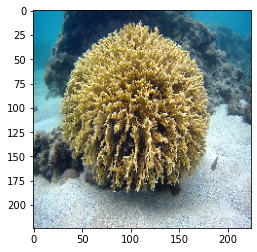

In [21]:
plt.imshow(imagem_correta/255)
preds = best_model.predict(np.expand_dims(imagem_correta, axis=0)) #Predição de uma única imagem
soft_preds=tf.nn.softmax(preds).numpy().flatten()
decode_prof=decode(soft_preds)
for list_prob in decode_prof[:3]:
    print('Classe: {} - Probabilidade: {:.6f}'.format(list_prob[0], list_prob[1])) 

In [22]:
explainer_correta = lime_image.LimeImageExplainer()

In [23]:
%%time
explanation_correta = explainer_correta.explain_instance(imagem_correta.astype('double'), best_model.predict, top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 30.1 s, sys: 3.08 s, total: 33.2 s
Wall time: 28 s


### Para a Classe mais provável

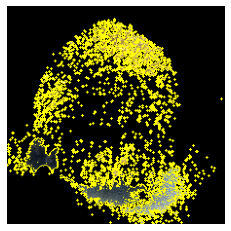

In [32]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[0], positive_only=True, num_features=20, hide_rest=True)
img=plt.imshow(mark_boundaries(temp /255, mask))
plt.axis('off')
plt.show();

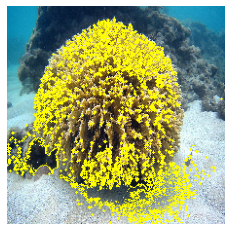

In [33]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[0], positive_only=True, num_features=20, hide_rest=False)
img=plt.imshow(mark_boundaries(temp /255, mask))
plt.axis('off')
plt.show();

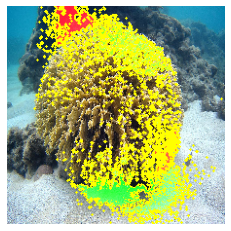

In [34]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
img=plt.imshow(mark_boundaries(temp /255, mask))
plt.axis('off')
plt.show();

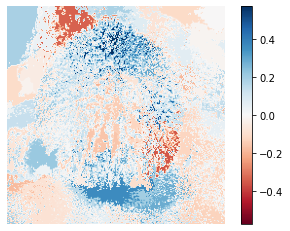

In [35]:
#Selecionar a classe mais provável
ind =  explanation_correta.top_labels[0]

#Mapeamento os pesos para cada explicação
dict_heatmap = dict(explanation_correta.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_correta.segments) 

#Plot
img=plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.axis('off')
plt.show();

### Para segunda classe mais provavel

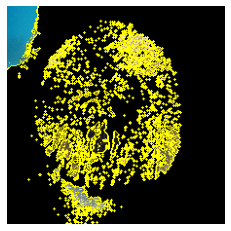

In [36]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[1], positive_only=True, num_features=20, hide_rest=True)
img=plt.imshow(mark_boundaries(temp /255, mask))
plt.axis('off')
plt.show();

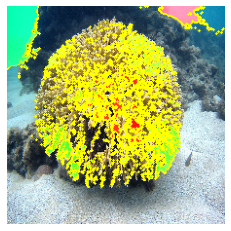

In [37]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[1], positive_only=False, num_features=20, hide_rest=False)
img=plt.imshow(mark_boundaries(temp /255, mask))
plt.axis('off')
plt.show();

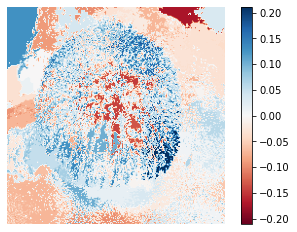

In [38]:
#Selecionar a classe mais provável
ind =  explanation_correta.top_labels[1]

#Mapeamento os pesos para cada explicação
dict_heatmap = dict(explanation_correta.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_correta.segments) 

#Plot
img=plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.axis('off')
plt.show();